<a href="https://colab.research.google.com/gist/simonlobgromov/247b099e3cc80d48ab15e35312ce1215/dt_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

конспект ML. Выполнил Павлов Д.Н. (2024 г.)

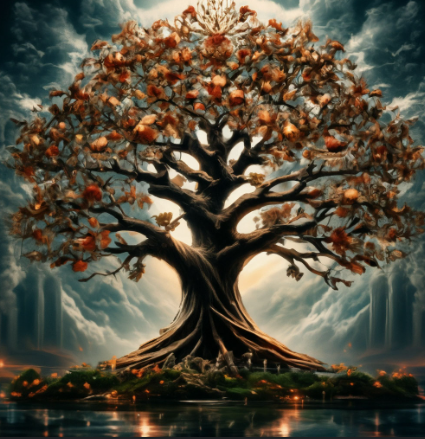

# Decision Trees

**Решающие деревья** (Decision Trees) — это алгоритм машинного обучения, который принимает решения, исходя из последовательных вопросов о данных. Давайте приведем аналогию.

Представьте, что вы пришли к врачу с жалобой "плохое самочувствие". Задача врача - поставить точный диагноз. Какие действия он предпринимает? Первоочередным является сбор анамнеза и выявление симптоматики. Симптомы - это Признаки, Синдром - это некоторые закономерности и патогенетические взаимосвязи симптомов, а диагноз - целевое значение. Итак, представьте диалог:
- Беспокоят ли вас боли в подвздошной области и внизу живота?
  * Если нет, то исключаем Аппендицит.
- Есть ли температура?
  * Да - есть воспалительный процесс
- Болит ли горло?
  * Если Да - воспаление ВДП.
- Боль при глотании, гнойные образования на задней стенке?
  * Да! У Вас Ангина!

Диагноз поставлен!

Диалог строится как цепь уточняющих вопросов от более общих к более частным, где на каждом этапе исключаются одни предположения о диагнозе и последовательно уточняется наиболее вероятное заболевание.

Примерно так и работает решающее дерево. Алгоритм можно представить в виде логической структуры, похожей на граф, где каждый шаг — это проверка какого-либо условия. В итоге в общем виде дерево помогает разделить данные на группы, которые соответствуют возможным решениям или прогнозам.

В отличие от **линейных моделей**, которые полагаются на простые математические уравнения для поиска взаимосвязей, решающие деревья принимают решения, основываясь на логических условиях. Это позволяет им обрабатывать сложные и нелинейные зависимости, что делает их более гибкими в случаях, когда данные трудно описать с помощью прямых или плоскостей.

Будет очень не лишним изучить [статью от `sklearn`](https://scikit-learn.org/stable/modules/tree.html#tree).

In [19]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display, clear_output

# make a plotting function
def plot_tree(decision_tree, column_names, width=1500):
    dot_data = tree.export_graphviz(decision_tree,
                                out_file=None,
                                feature_names=column_names)

    graph = pydotplus.graph_from_dot_data(dot_data)


    return Image(graph.create_png(), width=width)

In [ ]:
df = sns.load_dataset('iris')

In [ ]:
df

sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]

In [ ]:
df.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [ ]:
df = df.loc[df.species.isin(['versicolor', 'virginica']), ['petal_length',	'petal_width', 'species']]

In [ ]:
df.head(3)

petal_length  petal_width     species
50           4.7          1.4  versicolor
51           4.5          1.5  versicolor
52           4.9          1.5  versicolor

<Axes: xlabel='petal_length', ylabel='petal_width'>

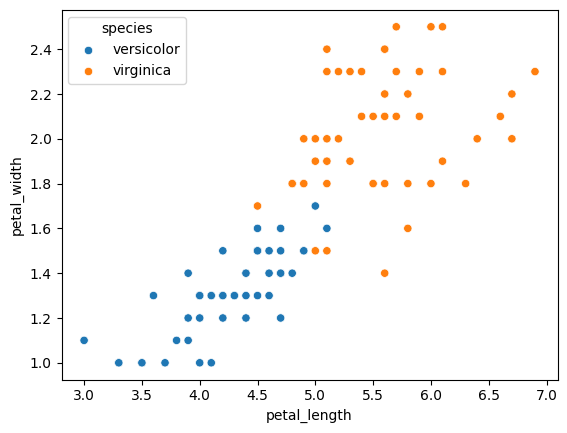

In [ ]:
sns.scatterplot(x=df.petal_length, y=df.petal_width, hue=df.species)

Чтобы показать принцип работы решающего дерева, формализуем задачу. Перед нами хорошо известный датасет "Ирисы Фишера". Отберем из него два вида цветка и два признака чтобы смоделировать задачу бинарной классификации. Этот пример наилучшим образом даст представление о том, как работает новый алгоритм. Видим картину условной линейной разделимости с частичным перекрыванием классов. Линейное разделение неизбежно даст некоторый процент ошибок, однако, если отбросить проблему "переобучения", дерево способно разделить классы со 100% точностью. Это может быть как преимуществом, так и проблемой. Как же оно работает?

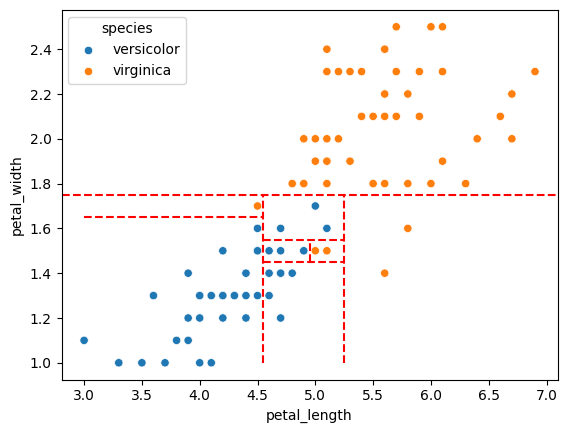

In [ ]:
sns.scatterplot(x=df.petal_length, y=df.petal_width, hue=df.species)
plt.axhline(1.75, color='red', linestyle='dashed')
plt.plot(np.array([5.25, 5.25]), np.array([1, 1.75]), '--r')
plt.plot(np.array([4.55, 4.55]), np.array([1, 1.75]), '--r')
plt.plot(np.array([3, 4.55]), np.array([1.65, 1.65]), '--r')
plt.plot(np.array([4.55, 5.25]), np.array([1.55, 1.55]), '--r')
plt.plot(np.array([4.55, 5.25]), np.array([1.45, 1.45]), '--r')
plt.plot(np.array([4.95, 4.95]), np.array([1.45, 1.55]), '--r')

Если данное признаковое пространство "Нарезать" на области многократно применяя "Разделение" выбрав соответствующий Признак и "Порог", то увидим, что каждый объект может быть однозначно проклассифицирован. На данном изображении мы видим границы, значения для которых мы подобрали "руками".

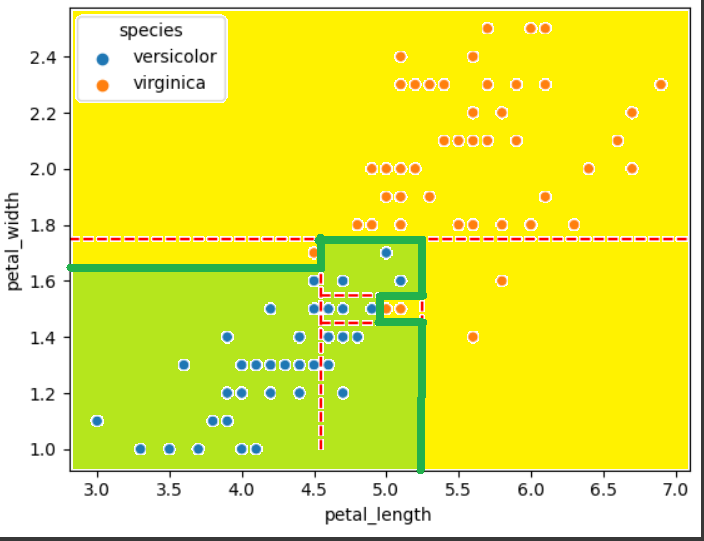

Формально, для отделения класса `virginica` набор границ можно записать в виде булевых операций:

```
(petal_length< 4.55 & petal_width > 1.65) | (4.55 < petal_length< 5.25 & petal_width > 1.75) | (petal_length > 5.25 & petal_width > 0) | (4.95 < petal_length< 5.25 & 1.45 < petal_width < 1.55)
```



$\left[
      \begin{gathered}
        \begin{cases}
          petal\;\;length < 4.55       \\
          petal\;\;width > 1.65
        \end{cases} \\
                \begin{cases}
          4.55 < petal\;\;length< 5.25       \\
          petal\;\;width > 1.75
        \end{cases} \\
                \begin{cases}
          petal\;\;length > 5.25       \\
          petal\;\;width > 0
        \end{cases} \\
                \begin{cases}
          4.95 < petal\;\;length< 5.25       \\
          petal\;\;width < 1.55
        \end{cases} \\
      \end{gathered}
\right.$

Пропишем данные условия в виде настоящего кода:

In [ ]:
df['species_pred'] = df.apply(lambda i: 'virginica' if
         (i['petal_length']< 4.55 and i['petal_width'] > 1.65) or
         (4.55 < i['petal_length']< 5.25 and i['petal_width'] > 1.75) or
         (i['petal_length'] > 5.25 and i['petal_width'] > 0) or
         (4.95 < i['petal_length']< 5.25 and 1.45 < i['petal_width'] < 1.55)
         else 'versicolor' , axis=1)

In [ ]:
df

petal_length  petal_width     species species_pred
50            4.7          1.4  versicolor   versicolor
51            4.5          1.5  versicolor   versicolor
52            4.9          1.5  versicolor   versicolor
53            4.0          1.3  versicolor   versicolor
54            4.6          1.5  versicolor   versicolor
..            ...          ...         ...          ...
145           5.2          2.3   virginica    virginica
146           5.0          1.9   virginica    virginica
147           5.2          2.0   virginica    virginica
148           5.4          2.3   virginica    virginica
149           5.1          1.8   virginica    virginica

[100 rows x 4 columns]

На основании описанного выше Булевого условия сделали прогноз и теперь оценим его точность:

In [ ]:
print(f'Accuracy score: {(df.species == df.species_pred).sum() / df.shape[0]}')

Accuracy score: 0.99


Где-то там была допущена одна ошибка, но мы сделаем вид, что ничего не было))))

Какая эвристика используется для более эффективного разбиения? Этот процесс поэтапный, формулируемый как "От общего к частному, от глобальнгого к мелочам!" Самое первое разделение мы делаем таким образом, чтобы отделить разом максимальное количество объектов одного класса. С другой стороны границы останутся представители обоих классов и с ними поступаем также. Таким образом речь идет о рекурсивном алгоритме. Он может продолжаться до тех пор пока классы не будут поделены полностью или же остановиться при условии какого-либо критерия остановки. Напишем псевдокод данного алгоритма:

```
Функция ПостроитьДерево(Данные):

    1. Найти такое разделение данных по какому-либо признаку, которое максимизирует количество объектов одного класса в одной группе.
    
    2. Если группа данных содержит объекты разных классов:
        2.1. Для каждой подгруппы данных:
            2.1.1. Найти такое разделение подгруппы по другому признаку, которое максимально отделяет объекты одного класса.
            2.1.2. Повторить этот процесс для каждой подгруппы.
    
    3. Повторять процесс для каждой подгруппы, пока в каждой из них не останутся только объекты одного класса.
    
    4. Вернуть структуру дерева с признаками разбиения и соответствующими подгруппами.
```


Как выглядят этапы разбиений для нашего случая:

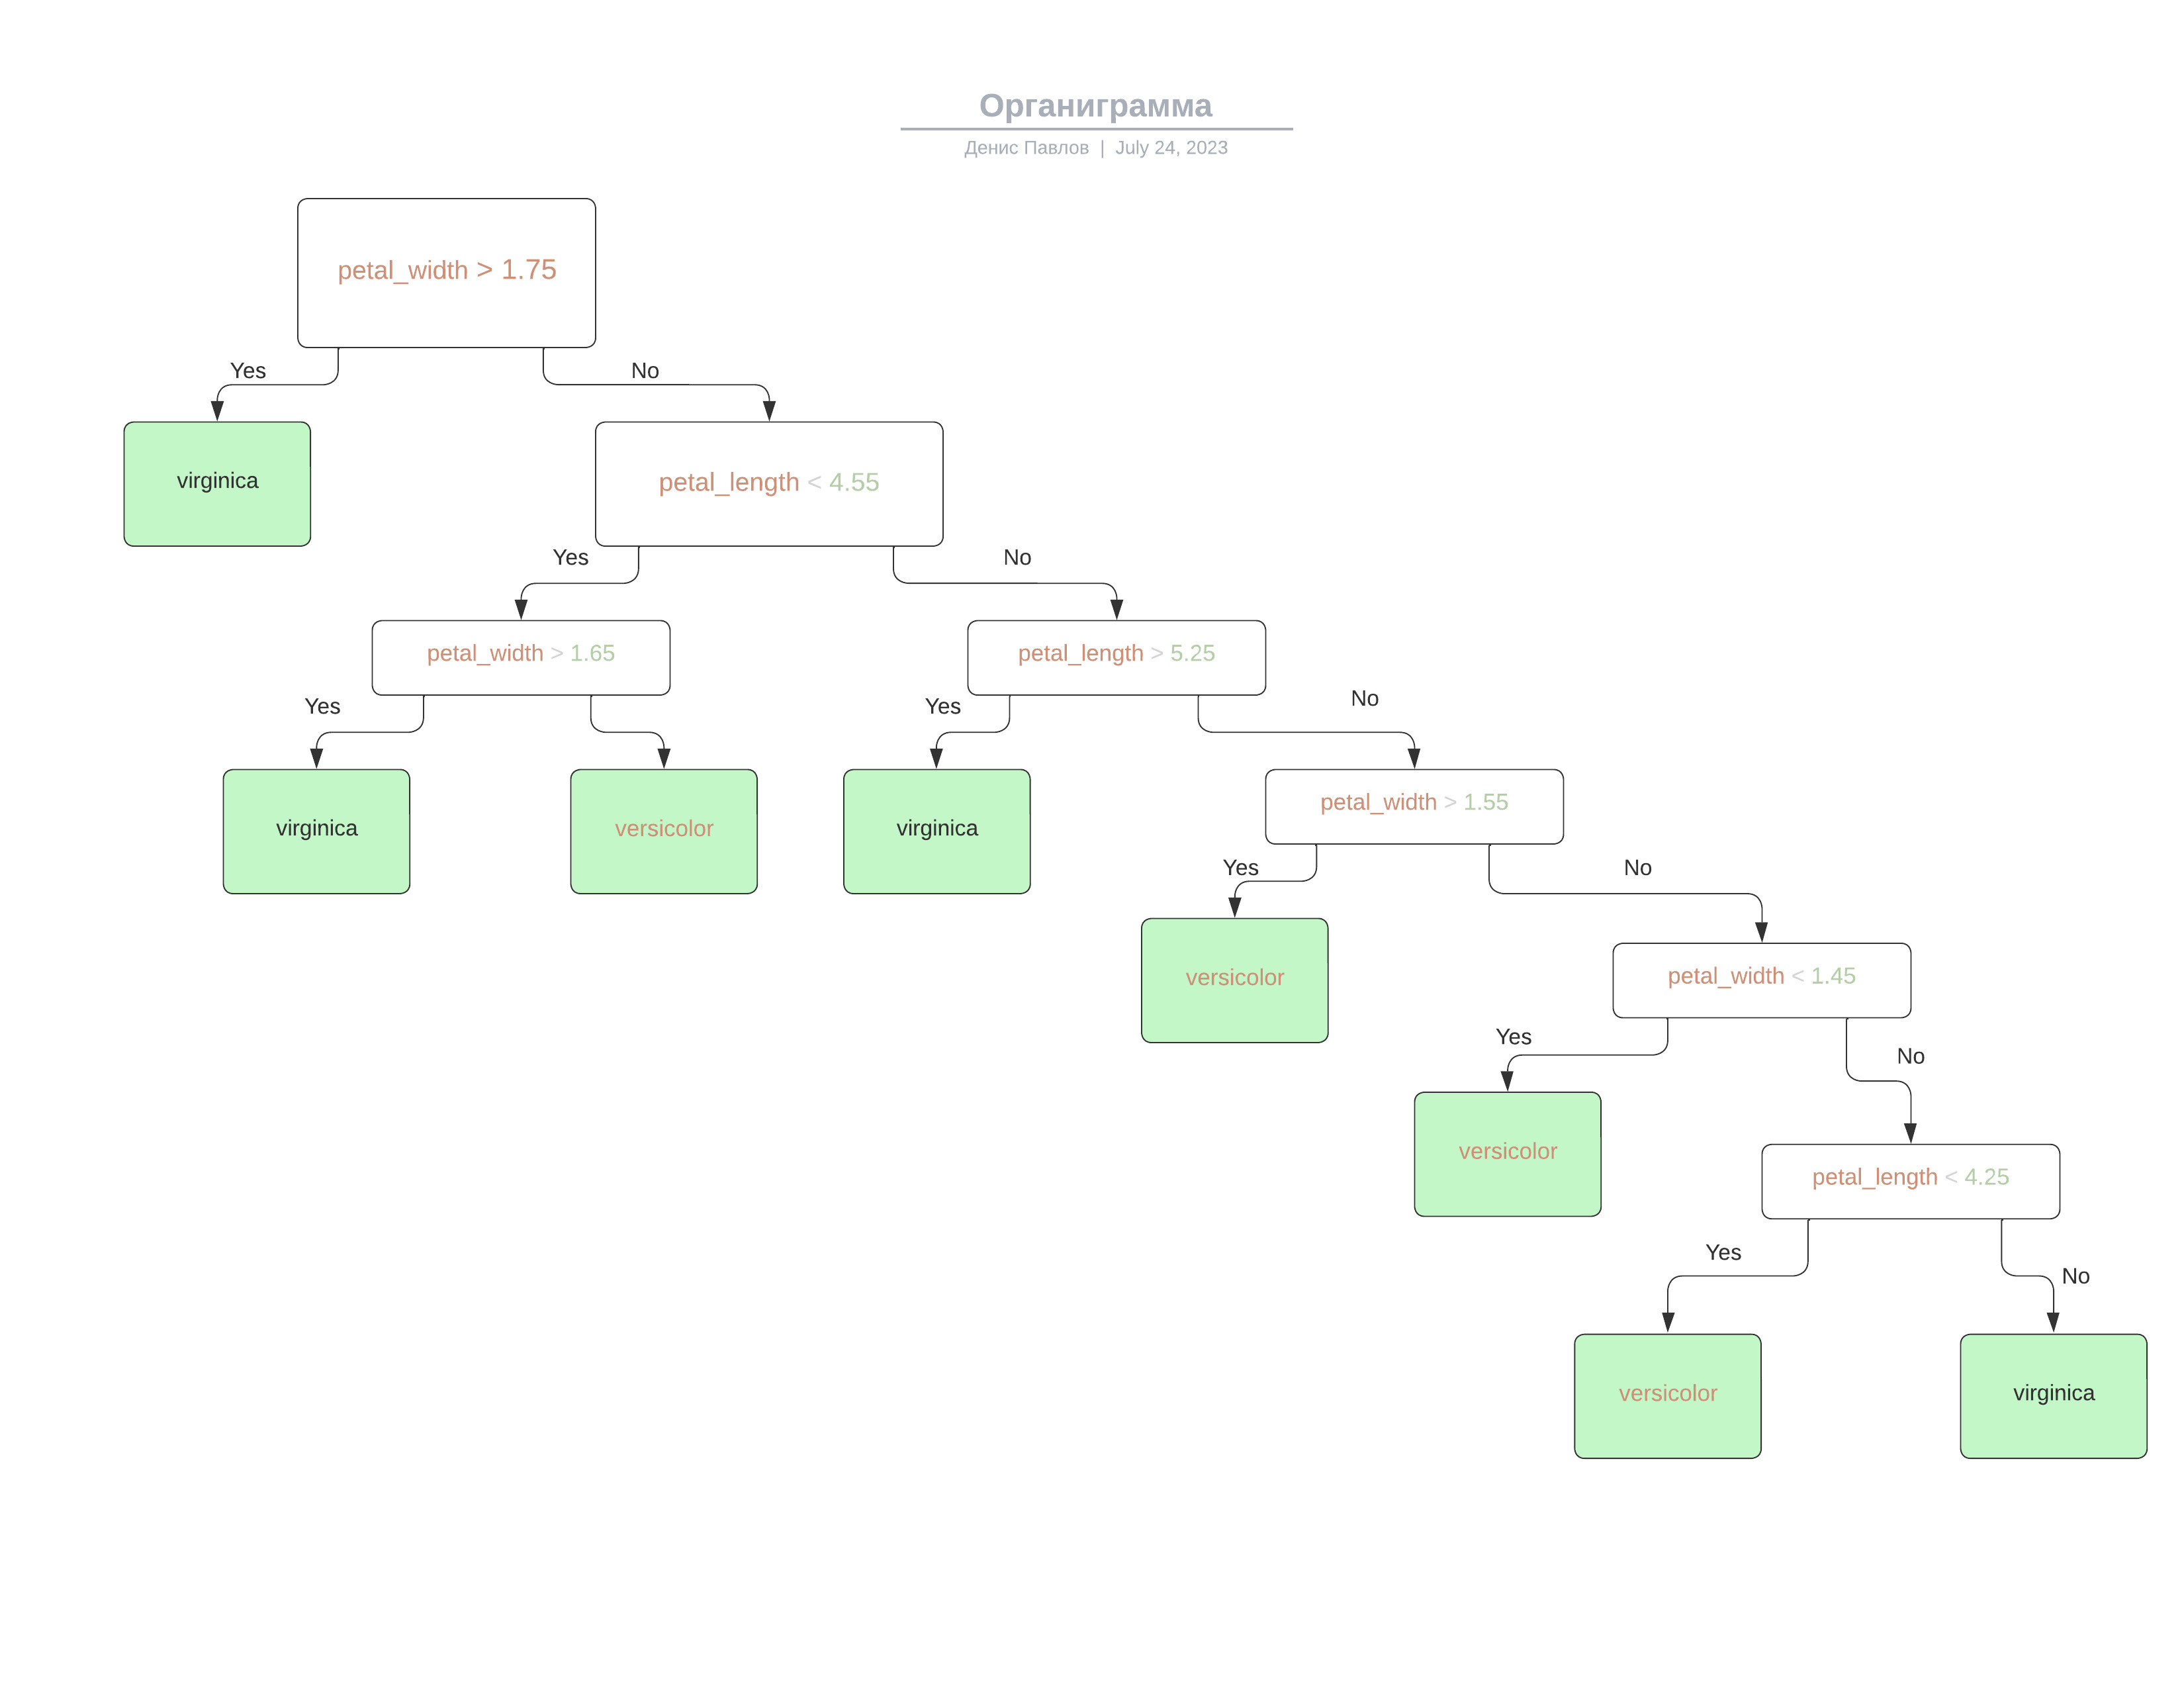

Данная структура и есть "Дерево решений". На схеме присутствуют основные характерные объекты. Введем терминологию:


1. **Корневой узел** — это первый узел в решающем дереве, с которого начинается процесс разделения данных. Он представляет собой исходную точку, где принимается первое решение на основе выбранного признака. Все остальные узлы в дереве исходят из этого корневого узла. В корневом узле обязательно присутствуют:
  * Наименование признака по которому берется порог
  * Значение порога
  * Метрика качества разбиения (В готовых алгоритмах)

2. **Вершина** — это любая точка (узел) в решающем дереве, которая следует за **Корневым узлом** или другой Вершиной и в ней происходит разделение только по тем объектам, которые прошли в эту вершину по бинарному(-ым) условию(-ям) родительской(-их) вершины(вершин) или корневого узла. В вершине также обязательно присутствуют:
  * Наименование признака по которому берется порог
  * Значение порога
  * Метрика качества разбиения (В готовых алгоритмах)

3. **Лист** — это конечный узел в дереве, в котором больше не происходит разделение. Лист содержит итоговое решение или прогноз, который был получен на основе предыдущих разбиений. В случае задачи классификации, лист указывает на предсказанный класс, а в задаче регрессии — на числовое значение. В идеальном (чаще переобученном) случае лист содержит объекты только одного класса или значения, которые очень близки к TRUE-значениям целевой переменной в случае задачи регрессии.

4. **Слой** - новое "поколение" дочерних узлов или концевых верширн (листьев). Количество слоев - это основная характеристика дерева, именуемая "ГЛУБИНА". В нашем случае глубина равна 6.

Именно поэтому дерево также в общем смысле называют ЛОГИЧЕСКИМ ГРАФОМ.

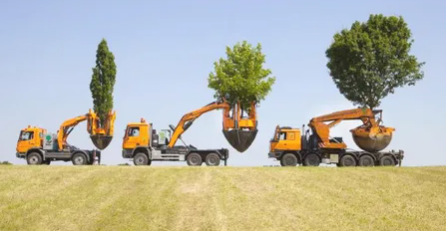

# Как  автоматизировать процесс построения дерева?

В первом примере мы решали задачу "руками" подбирая пороги разбиения интуитивно, с оглядкой на диаграмму рассеяния. Но, как всегда, нам хочется этот процесс автоматизировать. В этом случае для выбора признака для разбиения и порога по нему мы должны оптимизировать какой-либо критерий наилучшего разбиения или функционал качества разбиения чтобы процесс был максимально эффективным. Да, МЛ это все время про оптимизацию... Что за критерии такие??

# Критерии разбиения и функционал качества разбиения

$H(R)$ - мера "неоднородности" или "неопределенности" множества $R$, являющегося полной группой.

Пусть мы решаем задачу классификации на $K$ классов, и $[p_1, p_2, ..., p_k]$ - доли объектов (вероятности) классов $1, 2, ..., k$ во множестве $R$. Тогда мерами неопределенности могут быть:


1. **Misclassification criterion** (критерий ошибочной классификации):
$$H(R) = 1 - p_{max}$$

2. **Entropy criterion** (критерий энтропии):
$$H(R) = -\sum_{k=1}^{K} p_k \ln p_k$$

3. **Gini criterion** (критерий Джини):

$$H(R) = \sum_{k=1}^{K} p_k(1-p_k)$$

Эти формулы описывают три различных подхода к измерению неоднородности множества данных $R$ при классификации.

Ниже вы увидите иллюстрацию того, как работают критерии неоднородности для некоторого множества представленного двумя классами. Поиграйтесь данным симулятором. Вы сможете увидеть, что критерий неоднородности принимает максимальное значение в ситуации, когда классы представлены равным количеством объектов, и нулевое значение, когда выборка представлена только одним единственным классом. Это одинаково работает для любого количества классов.

In [18]:
# @title Код отрисовки графика

X = np.array([[1, 0], [1, 2], [1, 4], [0, 0], [0, 2], [0, 4]])

def entropy(n:int)->float:
  if n!=0 and n!=6:
    return round(-n/6 * np.log2(n/6) - (1 - n/6) * np.log2(1 - n/6), 3)
  else:
    return 0

def miss_cr(n:int)->float:
  return round(1 - max(n/6, (1-n/6)), 3)

def gini_cr(n:int)->float:
  p1 = n/6
  p2 = 1 - p1
  return round(p1*(1-p1) + p2*(1-p2), 3)

def get_info(n:int)->str:
  entr = entropy(n)
  miss = miss_cr(n)
  gini = gini_cr(n)
  info = f"$H(R)$:\nEntropy: {entr}\nGini: {gini}\nMissclass: {miss}"
  return info

slider_Class_A = widgets.FloatSlider(
    value= 3,
    min=0,
    max=6,
    step=1,
    description='Class_A'
)


def update_plot(A_value):

    A_value = int(A_value)
    n = A_value
    y = np.concatenate([np.array(['r']*n), np.array(['b']*(6-n))])
    plt.scatter(X[:, 1], X[:, 0], s=700, c=y)
    plt.text(-1, -2, get_info(n), fontsize=12, color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
    red_patch = mpatches.Patch(color='red', label='Class_A')
    blue_patch = mpatches.Patch(color='blue', label='Class_B')
    plt.legend(handles=[red_patch, blue_patch])
    plt.title(f'Соотношение представителей классов A и B: {n}/{6-n}')
    plt.xlim(-2, 6)
    plt.ylim(-3, 3)
    plt.show()


out = widgets.Output()

def on_slider_change(change):
    A_value = slider_Class_A.value


    with out:
        clear_output(wait=True)
        update_plot(A_value)

slider_Class_A.observe(on_slider_change, 'value')

display(widgets.VBox([slider_Class_A]))
display(out)

Output()

<ipython-input-14-3e470d5b5c72>:3: RuntimeWarning: divide by zero encountered in log2
  return -prob_1 * np.log2(prob_1) - (1 -prob_1) * np.log2(1 - prob_1)
<ipython-input-14-3e470d5b5c72>:3: RuntimeWarning: invalid value encountered in scalar multiply
  return -prob_1 * np.log2(prob_1) - (1 -prob_1) * np.log2(1 - prob_1)


Text(0, 0.5, '$H(p)$')

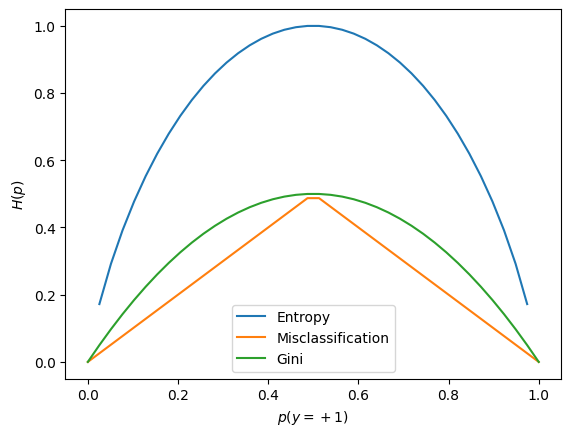

In [14]:
# @title Сравнительные графики критериев неоднородности
def entropy(prob_1:float)->float:
  return -prob_1 * np.log2(prob_1) - (1 -prob_1) * np.log2(1 - prob_1)

def miss_cr(prob_1:float)->float:
  return 1 - max(prob_1, (1-prob_1))

def gini_cr(prob_1:float)->float:
  p1 = prob_1
  p2 = 1 - p1
  return p1*(1-p1) + p2*(1-p2)


entropy = np.vectorize(entropy)
miss_cr = np.vectorize(miss_cr)
gini_cr = np.vectorize(gini_cr)

prob = np.linspace(0, 1, 40)
entr_ = entropy(prob)
miss_ = miss_cr(prob)
gini_ = gini_cr(prob)

sns.lineplot(x=prob, y=entr_, label='Entropy')
sns.lineplot(x=prob, y=miss_, label='Misclassification')
sns.lineplot(x=prob, y=gini_, label='Gini')
plt.xlabel('$p(y=+1)$')
plt.ylabel('$H(p)$')

## Impurity (информативность)

Как мы уже поняли, что дерево строится путем многократного разбиения данных по какому-либо признакоу по какому либо порогу. Выбрав признак и порог, мы можем поделить все множество наблюдений $R$ на две части:
* Левую $R_l$
* Правую $R_r$

В каждой части могут быть представители любого из классов (их может быть 2 и более). Полезно будет измерить МЕРУ НЕОДНОРОДНОСТИ как исходного множества $R$, так и полученных множеств $R_l$ и $R_r$. Чтобы понять, насколько хорошо наше разбиение, мы используем следующий функционал качества, который также называется "Информационный выигрыш":

$$Q(R, j, s) = H(R) - \frac{|R_l|}{|R|}H(R_l) - \frac{|R_r|}{|R|}H(R_r) \to max_{j, s}  $$

Где
* $R$ - множество до разбиения
* $j$ - выбранный признак для разбиения
* $s$ - значение выбранного признака в качестве порога разбиения
* $|R|$ - Мощность множества $R$, то есть количество наблюдений в исходном множестве
* $|R_l|$ - Количество наблюдений которое осталось "слева" от порога
* $|R_r|$ - Количество наблюдений которое осталось "справа" от порога.
* $H(R_{...})$ - Критерий неоднородности.

Если внимательно посмотреть на формулу, можно прийти к выводу, что максимум информативности достигается тогда, когда критерий неоднородности одной из "половин" равен нулю.

Так задача сводится к "Перебору" каждого признака с каждым возможным порогом с выбором той конфигурации, когда информационный выигрыш будет максимальным.

Ниже написан пример, как подбирается порог для признака `petal_width` датасета с Ирисами (выбрал только один признак дабы избавить себя от написания длинного кода.. лень, господа..). Подберите наиболее оптимальный порог. Можете также адаптировать этот код для другого признака.

In [ ]:
# @title Симулятор Информационного выигрыша по одному из признаков

def entropy(p1:int)->float:
  if p1!=0 and p1!=1:
    return -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)
  else:
    return 0

def data_inf(data, petal_width_trh = None, left_right=None):
  if left_right==None:
    R = df.shape[0]
    p1 = df.species.value_counts().values[0] / R
    p2 = 1-p1
    return R, p1, p2
  elif left_right=='left':
    data = df[df.petal_width < petal_width_trh]
    R = data.shape[0]
    p1 = data.species.value_counts().values[0] / R
    p2 = 1-p1
    return R, p1, p2
  elif left_right=='right':
    data = df[df.petal_width >= petal_width_trh]
    R = data.shape[0]
    p1 = data.species.value_counts().values[0] / R
    p2 = 1-p1
    return R, p1, p2


def impurity(petal_width_trh)->float:
  return entropy(data_inf(df)[1]) - data_inf(df, petal_width_trh, 'left')[0]/df.shape[0] * entropy(data_inf(df, petal_width_trh, 'left')[1]) - data_inf(df, petal_width_trh, 'right')[0]/df.shape[0] * entropy(data_inf(df, petal_width_trh, 'right')[1])

thr_plot = np.linspace(df.petal_width.min()+.01, df.petal_width.max()-.01, 100)
imp_fun = np.vectorize(impurity)
imp_plot = imp_fun(thr_plot)

slider_tr = widgets.FloatSlider(
    value= 1,
    min=df.petal_width.min() + .01,
    max=df.petal_width.max() - .01,
    step=.02,
    description='Порог'
)


def update_plot(petal_width_trh):

    petal_width_trh = float(petal_width_trh)
    imp = impurity(petal_width_trh)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.scatterplot(x=df.petal_length, y=df.petal_width, hue=df.species, ax=ax[0])
    ax[0].axhline(petal_width_trh, color='black', linestyle='--')
    sns.lineplot(x=thr_plot, y=imp_plot, color='black', ax=ax[1])
    ax[1].scatter([petal_width_trh], [imp], color='red', s=100)
    ax[1].set_xlabel('Значение порога')
    ax[1].set_ylabel('Impurity')
    if imp == imp_plot.max():
      ax[1].text(1.3, 0.1, f'Impurity: {round(imp, 3)}', fontsize=18, color='black',
              bbox=dict(facecolor='green', edgecolor='red', boxstyle='round,pad=0.1'))
    else:
      ax[1].text(1.3, 0.1, f'Impurity: {round(imp, 3)}', fontsize=18, color='black',
              bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.1'))

    fig.suptitle('Зависимость значения информационного выигрыша\nот порога зазбиения.')

    plt.show()


out = widgets.Output()

def on_slider_change(change):
    A_value = slider_tr.value

    with out:
        clear_output(wait=True)
        update_plot(A_value)

slider_tr.observe(on_slider_change, 'value')

display(widgets.VBox([slider_tr]))
display(out)

Output()

# Practical task

Перейдем к другому примеру. Перед нами шары двух цветов, расположенные вдоль оси X. Так мы получаем задачу бинарной классификации при одном количественном признаке. Разумеется, линейное разделение в данном случае предполагает однократное разделение по некоторому значению Х что никак не решит нашу задачу. Логический граф с этим справится намного лучше!

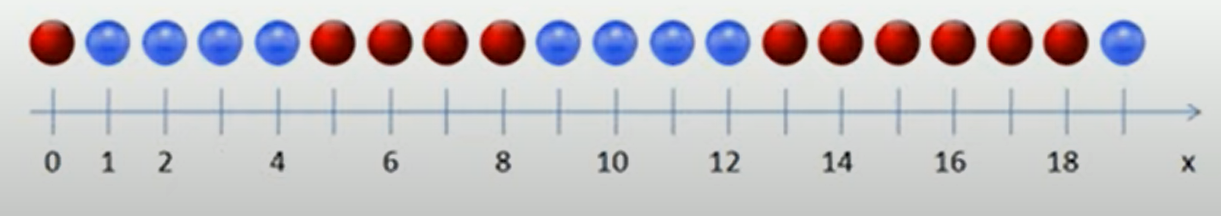

Напишем решение задачи классификации используя энтропийный критерий.

In [ ]:
balls = pd.DataFrame({'X' : [i for i in range(20)], 'color': ['red', 'blue', 'blue', 'blue', 'blue',
                                                              'red', 'red', 'red', 'red', 'blue', 'blue',
                                                              'blue', 'blue', 'red', 'red', 'red', 'red',
                                                              'red', 'red', 'blue']})

In [ ]:
balls.head()

X color
0  0   red
1  1  blue
2  2  blue
3  3  blue
4  4  blue

Границу установим следующего вида:

$left < j \leq right$

In [25]:
def impurity(s: int, df: pd.DataFrame)-> float:

  def entpopy(labels: pd.Series)->float:
    prob_red = (labels == 'red').sum()/labels.shape[0]
    prob_blue = 1 - prob_red
    if (prob_red == 0) or (prob_blue == 0):
      return  0
    else:
      return - prob_red * np.log(prob_red)/np.log(2) - prob_blue * np.log(prob_blue)/np.log(2)

  # R_m range
  r_m_entropy = entpopy(df.color)

  # R_left range

  r_left = df.loc[df.X < s, 'color']
  r_left_entropy = entpopy(r_left)

  # R_right range

  r_right = df.loc[df.X >= s, 'color']
  r_right_entropy = entpopy(r_right)

  Q = r_m_entropy - r_left.shape[0]/df.shape[0]*r_left_entropy - r_right.shape[0]/df.shape[0]*r_right_entropy



  return Q



Посчитаем impurity для случая, когда мы моделим все наблюдения по порогу $x=6$:

In [ ]:
impurity(6, balls)

0.05908553270201977

Возможно, это не лучший порог. Переберем все пороги для наилучшего разделения.

Решим итеративную задачу оптимизации

In [ ]:
impurity_list = []
j_list = []
for j in range(1, 20):
  impurity_list.append(impurity(j, balls))
  j_list.append(j)

In [ ]:
impurity_list

[0.044673614309123755,
 0.0008060001334083688,
 0.024224933980689034,
 0.06697162675600965,
 0.12357055472510059,
 0.05908553270201977,
 0.023140813305950858,
 0.004853199997116642,
 7.361074828216019e-05,
 0.007299156760473879,
 0.03282471235096179,
 0.08034195021346352,
 0.16088518841412425,
 0.10810803226932597,
 0.06469870627974023,
 0.030518829095981664,
 0.007152914465886923,
 0.0008060001334083411,
 0.05993070646691556]

In [ ]:
j_list[impurity_list.index(max(impurity_list))]

13

Наилучшим порогом является значение $x=13$

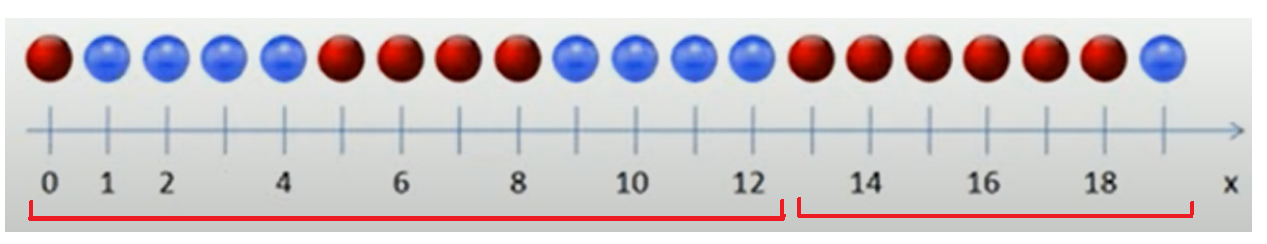

Так мы разбили множество на два подмножества. Это соответствует делению корневого узла дерева. Теперь каждое из подмножеств также необходимо разделить. То есть мы теперь для каждого подмножества решаем ту же задачу что и для полного множества при первом разбиении. Подберем для них пороги:

In [ ]:
impurity_list = []
j_list = []
for j in range(1, 13):
  impurity_list.append(impurity(j, balls.loc[balls.X<13]))
  j_list.append(j)
j_list[impurity_list.index(max(impurity_list))]

9

In [ ]:
impurity_list = []
j_list = []
for j in range(14, 20):
  impurity_list.append(impurity(j, balls.loc[balls.X>=13]))
  j_list.append(j)
j_list[impurity_list.index(max(impurity_list))]

19

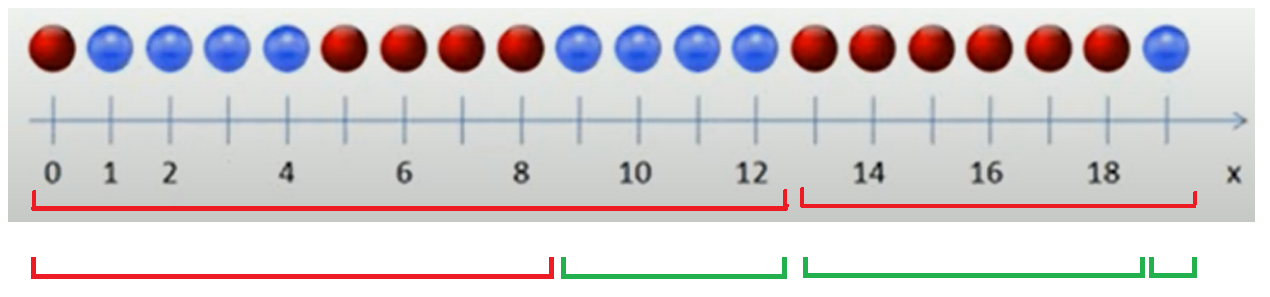

Так каждое из множеств было поделено на две части. Из полученных частей три полностью проклассифицированы.

Продолжим:

In [ ]:
impurity_list = []
j_list = []
for j in range(1, 9):
  impurity_list.append(impurity(j, balls.loc[balls.X<9]))
  j_list.append(j)
j_list[impurity_list.index(max(impurity_list))]

5

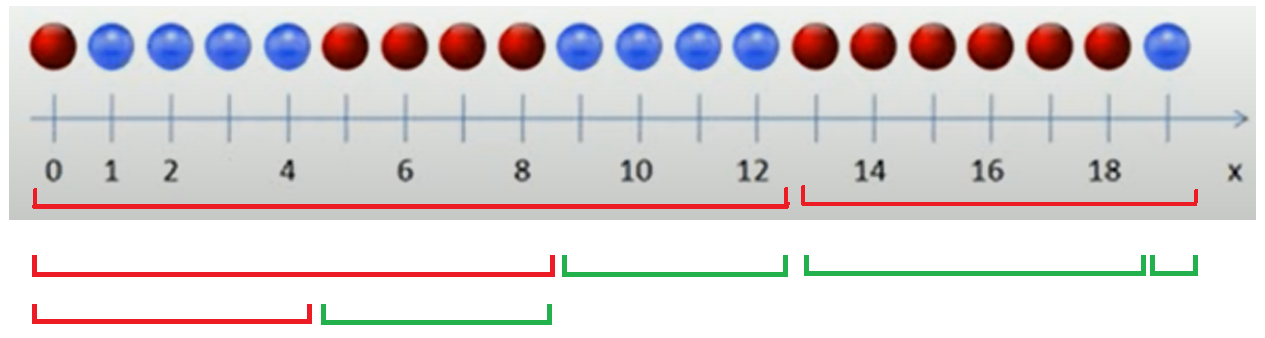

In [ ]:
impurity_list = []
j_list = []
for j in range(1, 5):
  impurity_list.append(impurity(j, balls.loc[balls.X<5]))
  j_list.append(j)
j_list[impurity_list.index(max(impurity_list))]

1

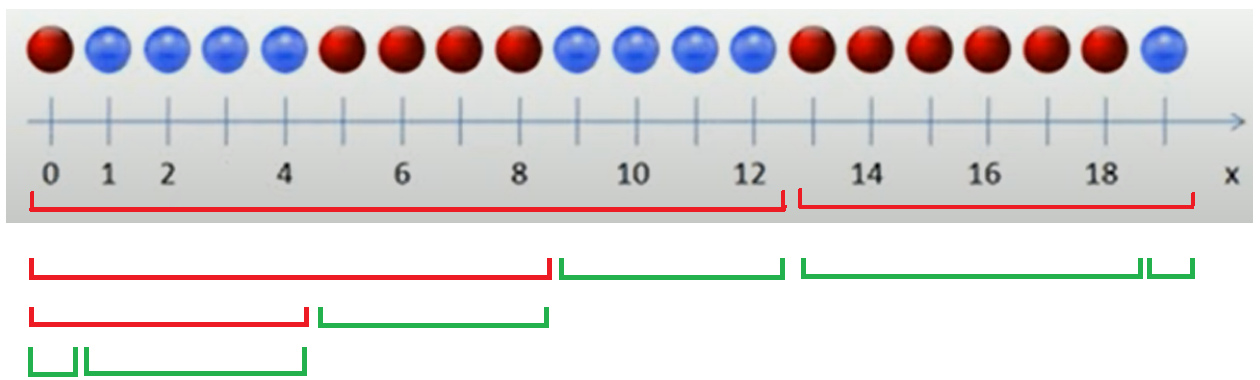

Получилось неплохо. Как бы повел себя готовый алгоритм "из коробки"?

In [ ]:
X = balls[['X']]
y = balls.color

обучение решающего дерева...

In [ ]:
dtc = tree.DecisionTreeClassifier(criterion='entropy')
dtc.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
(dtc.predict(X) == y).sum() / X.shape[0]

1.0

Дерево дало 100% верных ответов.

Отрисуем его логику выполнения классификации:

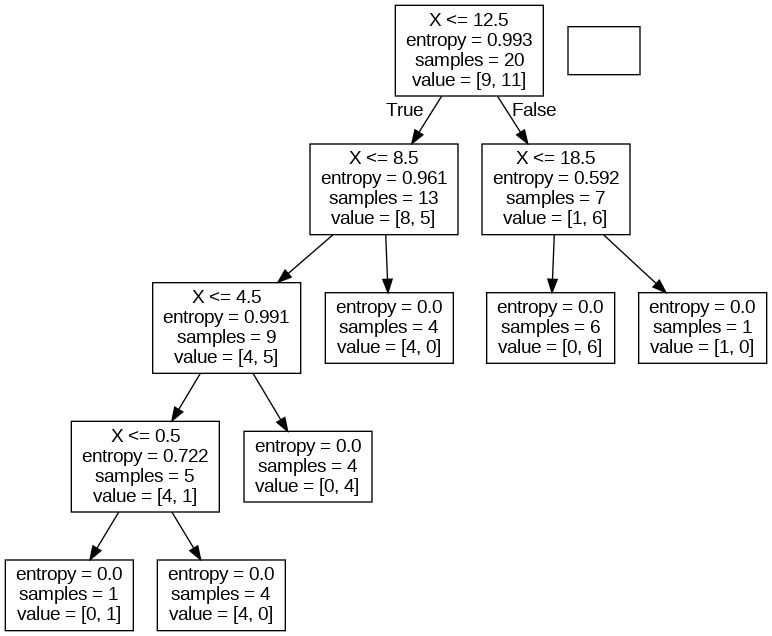

In [ ]:
plot_tree(dtc, balls[['X']].columns, 1000)

## Видим 100% сходство с нашими этапами решения!

Рассмотрите внимательно "дерево" и попытайтесь понять логику его работы.

# Task
Вернемся к Ирисам. Напишите свой классификатор "руками" согласно логике решающего дерева, ибо каждый в своей жизни должен вырастить хоть одно дерево)).

Можете использовать Энтропийный критерий или любой другой.

In [ ]:
df = sns.load_dataset('iris')
X = df[['petal_length', 'petal_width']]
y = df.species

In [ ]:
# your hard work

## Проверка готовым алгоритмом `DecisionTree`

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [ ]:
dtc = tree.DecisionTreeClassifier(criterion='entropy')

In [ ]:
dtc.fit(X, y)
y_pred = dtc.predict(X)

In [ ]:
print(f'Accuracy: {accuracy_score(y, y_pred)}')
print('\nConfusion matrix:')
confusion_matrix(y, y_pred)

Accuracy: 0.9933333333333333

Confusion matrix:


array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  0, 50]])

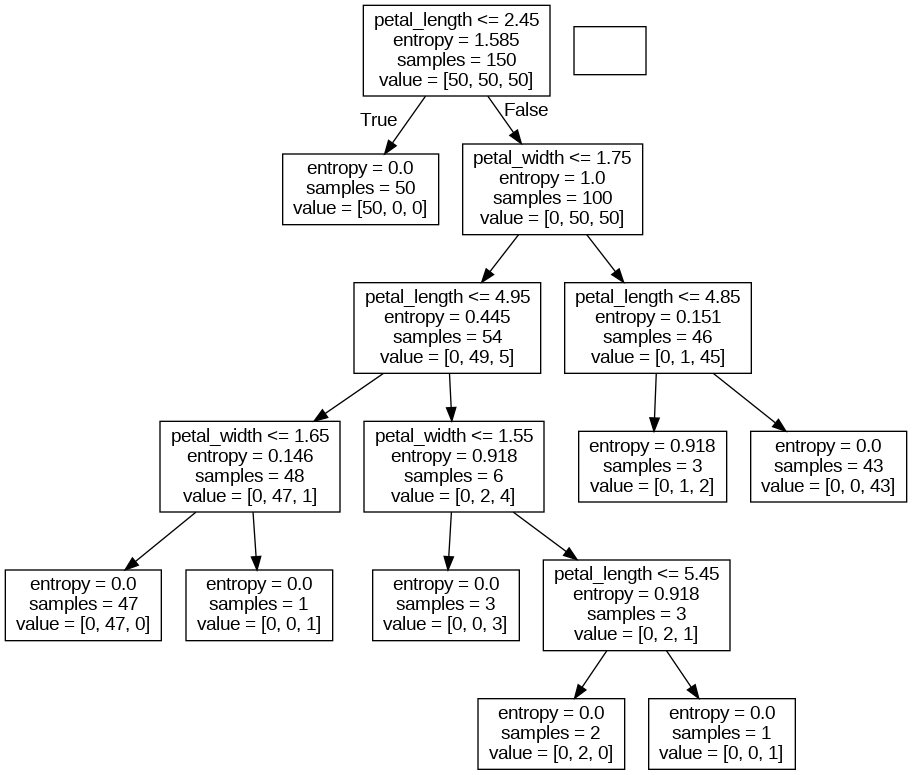

In [ ]:
plot_tree(dtc, X.columns, 500)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


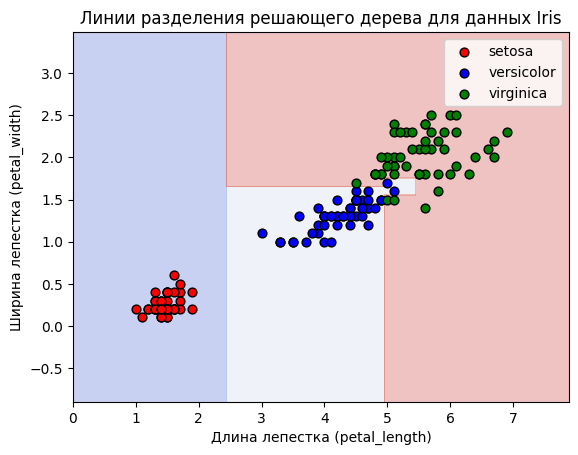

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
clf = DecisionTreeClassifier()
clf.fit(X, y_encoded)

def plot_decision_boundary(clf, X, y):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    species_unique = np.unique(y)
    colors = ['red', 'blue', 'green']

    for i, species in enumerate(species_unique):
        idx = y == species
        plt.scatter(X.loc[idx, 'petal_length'], X.loc[idx, 'petal_width'],
                    label=species, edgecolors='k', s=40, color=colors[i])

    plt.title('Линии разделения решающего дерева для данных Iris')
    plt.xlabel('Длина лепестка (petal_length)')
    plt.ylabel('Ширина лепестка (petal_width)')
    plt.legend()

plot_decision_boundary(clf, X, y)
plt.show()


Сравнение с логистической регрессией:

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X, y)
y_pred_lin = lr.predict(X)
print(f'Accuracy: {accuracy_score(y, y_pred_lin)}')
print('\nConfusion matrix:')
confusion_matrix(y, y_pred_lin)

Accuracy: 0.9666666666666667

Confusion matrix:


array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  2, 48]])

Как видим, дерево дало более точный результат!

# Pruning (стрижка)

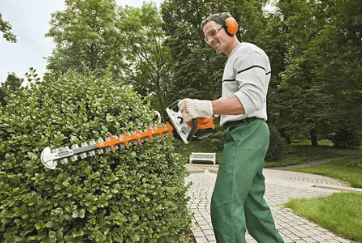

**Переобучение (overfitting)** — это ситуация, когда модель обучается слишком хорошо на обучающих данных, запоминая их детали, включая шум и случайные выбросы. Как видим, дерево способно очень хорошо "запомнить" все детали обучающей выборки и дать почти 100% точность на классификации (на регрессии тоже). Как вы знаете, это плохо скажется на качестве работы алгоритма на новых данных.

Причины переобучения для деревьев:
- **Глубокие деревья**: если не ограничивать максимальную глубину дерева, оно будет продолжать разбиение до тех пор, пока в каждом листе не окажется по одному объекту или пока объекты не будут идеально классифицированы. Это приводит к тому, что дерево становится слишком специфичным для обучающего набора.
- **Разбиение на мелкие группы**: если дерево продолжает разделять данные на очень маленькие группы (листья), оно может начать выделять случайные флуктуации в данных, что ухудшает его способность к обобщению.

### Борьба - Стрижка дерева (pruning)

**Стрижка дерева (pruning)** — это техника уменьшения размера дерева, чтобы предотвратить переобучение. Суть стрижки в том, чтобы удалить (или "состричь") лишние ветви дерева, которые не добавляют значимой информации или, наоборот, ухудшают качество предсказаний на новых данных.

Есть два основных типа стрижки:

1. **Pre-pruning (предварительная стрижка)**: дерево ограничивается во время его роста. В этом случае можно заранее установить ограничения на его максимальную глубину, минимальное количество объектов в каждом узле или минимальный прирост информации при каждом разбиении. Этот подход предотвращает рост дерева до чрезмерной глубины.
   
2. **Post-pruning (пост-стрижка)**: дерево сначала строится полностью, а затем его ветви, которые не приводят к значительному улучшению точности, удаляются. Этот метод эффективен тем, что дерево сначала может "разобраться" в структуре данных, а затем избавиться от лишних деталей. Тема устаревшая и в индустрии почти не используется...

### Пример стрижки дерева

При использовании таких библиотек, как `scikit-learn`, можно контролировать размер дерева с помощью гиперпараметров, таких как `max_depth` (максимальная глубина дерева), `min_samples_split` (минимальное количество объектов для разбиения) или `min_samples_leaf` (минимальное количество объектов в листе). Изучите как следует ДОКУМЕНТАЦИЮ к алгоритмам типа DesicionTree на официальном сайте `sklearn`!



## Data

Поэкспериментируем с датасетом, посвященным сорту риса (Бурый, Белый). Это задача бинарной классификации.

In [15]:
%%bash
kaggle datasets download -d mssmartypants/rice-type-classification
unzip -qq rice-type-classification.zip

Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification
License(s): copyright-authors



100%|██████████| 888k/888k [00:00<00:00, 47.0MB/s]


In [ ]:
rice = pd.read_csv('/content/riceClassification.csv').drop('id', axis=1)
rice

Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0      4537        92.229316        64.012769      0.719916        4677   
1      2872        74.691881        51.400454      0.725553        3015   
2      3048        76.293164        52.043491      0.731211        3132   
3      3073        77.033628        51.928487      0.738639        3157   
4      3693        85.124785        56.374021      0.749282        3802   
...     ...              ...              ...           ...         ...   
18180  5853       148.624571        51.029281      0.939210        6008   
18181  7585       169.593996        58.141659      0.939398        7806   
18182  6365       154.777085        52.908085      0.939760        6531   
18183  5960       151.397924        51.474600      0.940427        6189   
18184  6134       153.081981        51.590606      0.941500        6283   

       EquivDiameter    Extent  Perimeter  Roundness  AspectRation  Class  
0          76.004525  0.657536    273.085   0.764510      1.440796      1  
1          60.471018  0.713009    208.317   0.831658      1.453137      1  
2          62.296341  0.759153    210.012   0.868434      1.465950      1  
3          62.551300  0.783529    210.657   0.870203      1.483456      1  
4          68.571668  0.769375    230.332   0.874743      1.510000      1  
...              ...       ...        ...        ...           ...    ...  
18180      86.326537  0.498594    332.960   0.663444      2.912535      0  
18181      98.272692  0.647461    385.506   0.641362      2.916910      0  
18182      90.023162  0.561287    342.253   0.682832      2.925396      0  
18183      87.112041  0.492399    343.371   0.635227      2.941216      0  
18184      88.374495  0.489975    338.613   0.672274      2.967245      0  

[18185 rows x 11 columns]

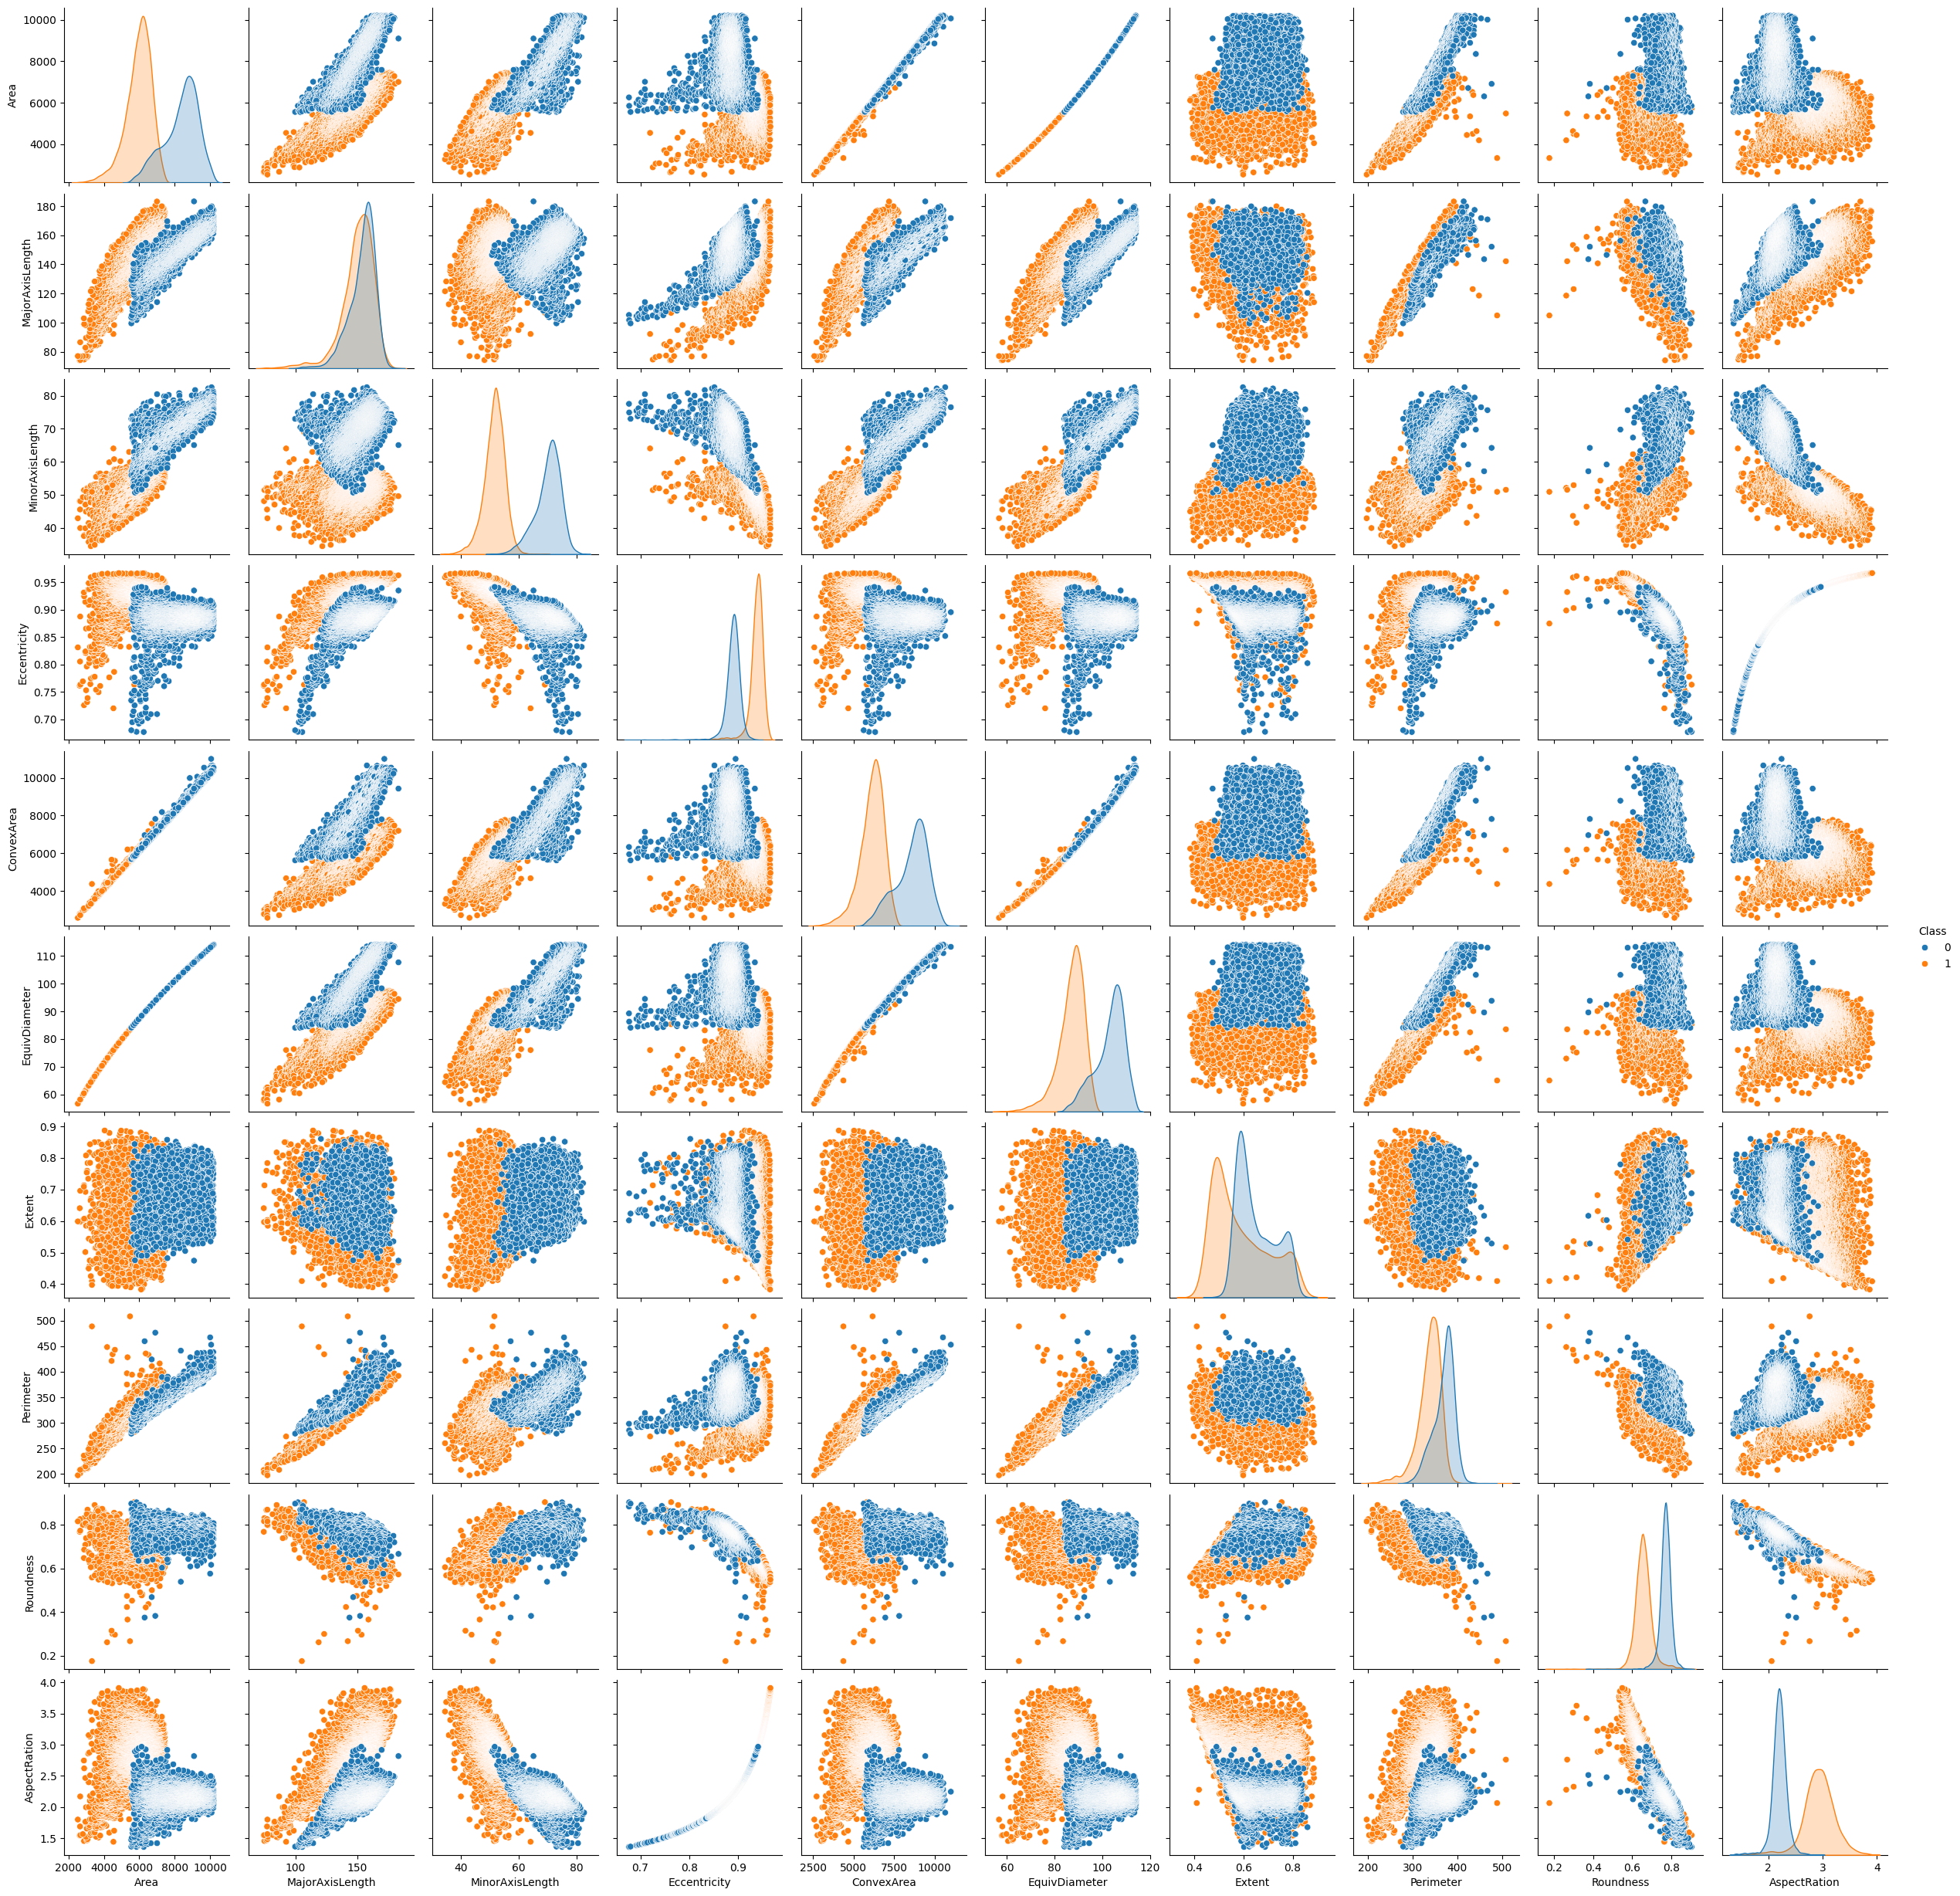

In [ ]:
# @title Не запускайте эту ячейку, иначе вам придется долго ждать!! Ооочень долго!!
# Не запускайте эту ячейку, иначе вам придется долго ждать!!
sns.pairplot(data=rice, hue='Class')

In [ ]:
rice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             18185 non-null  int64  
 1   MajorAxisLength  18185 non-null  float64
 2   MinorAxisLength  18185 non-null  float64
 3   Eccentricity     18185 non-null  float64
 4   ConvexArea       18185 non-null  int64  
 5   EquivDiameter    18185 non-null  float64
 6   Extent           18185 non-null  float64
 7   Perimeter        18185 non-null  float64
 8   Roundness        18185 non-null  float64
 9   AspectRation     18185 non-null  float64
 10  Class            18185 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 1.5 MB


Видим, что в данных нет пропусков и все признаки числовые. Это очень хорошо. Надо помнить что при использовании решающего дерева `DecisionTree` от `sklearn` не должно быть
* Пропусков
* Строчных колонок (с текстом)

Однако, деревья чаще всего не нуждаются в том, чтобы признаки масштабировались. Подумайте почему?

 В некотторых случаях можно прологарифмировать таргет (если у нас регрессия) чтобы снизить разброс и укоротить хвосты.. Порой, это стабилизирует алгоритм и повышает его эффективность.

### Поделим данные на тренировочные и тестовые.

In [ ]:
X = rice.drop('Class', axis=1)
y = rice.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=10)

### Обучим алгоритм при дефолтных гиперпараметрах и оценим качество

**Кстати, вопрос**: Можно ли для дерева применять оценку ROC-AUC? Почему?

In [ ]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

In [ ]:
print('TRAIN:')
print(f'Accuracy: {accuracy_score(y_train, y_pred_train)}')
print(f'F1: {f1_score(y_train, y_pred_train)}')
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred_train))
print('\nTEST:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'F1: {f1_score(y_test, y_pred_test)}')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_test))

TRAIN:
Accuracy: 1.0
F1: 1.0
Confusion matrix:
[[6107    0]
 [   0 7531]]

TEST:
Accuracy: 0.9830657576424016
F1: 0.9843017329255861
Confusion matrix:
[[2056   37]
 [  40 2414]]


Типичненько! Дерево стало "шибко умным", то есть переобучилось. Оно дало 100% результат на обучении и натворило ошибок на тесте. Стоит посмотреть, как меняется соотношение качества на обучении и на тесте при изменении гиперпараметров. Пострижём дерево, господа!

Переберем разные значения по гиперпараметру `max_depth`, который ограничивает рост дерева по количеству разбиений (Пример: если корневой узел разбился на 2 вершины и рост дерева на этом прекратился, то его глубина равна 1):

In [ ]:
from tqdm import tqdm
error_train_f1 = []
error_test_f1 = []
for max_depth in tqdm(range(1, 41)):
  dtc = tree.DecisionTreeClassifier(max_depth=max_depth)
  dtc.fit(X_train, y_train)
  y_pred_train = dtc.predict(X_train)
  y_pred_test = dtc.predict(X_test)
  error_train_f1.append(1-f1_score(y_train, y_pred_train))
  error_test_f1.append(1-f1_score(y_test, y_pred_test))

100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


Text(0.5, 0, 'Max Depth')

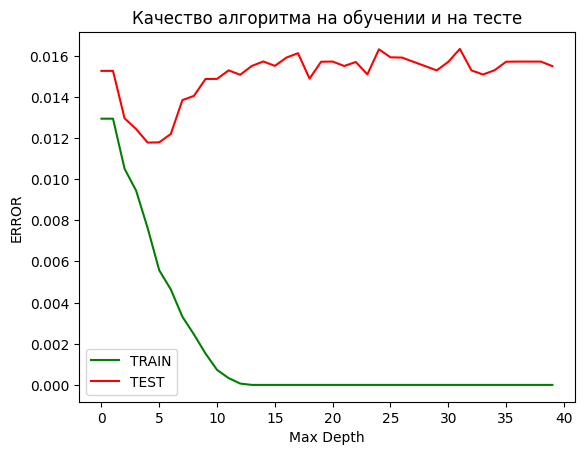

In [ ]:
sns.lineplot(error_train_f1, color='green', label='TRAIN').set_title('Качество алгоритма на обучении и на тесте')
sns.lineplot(error_test_f1, color='red', label='TEST')
plt.ylabel('ERROR')
plt.xlabel('Max Depth')

Так мы можем отследить такое значение гиперпараметра `max_depth`, при котором будут достигнуты наилучшие показатели на тестовой выборке. Когда дерево продолжит расти дальше, то будет улучшаться прогноз на обучающей выборке и ухудшаться на отложенной.
ВЫВОД - С РОСТОМ СЛОЖНОСТИ АЛГОРИТМА СНИЖАЕТСЯ ЕГО ОБОБЩАЮЩАЯ СПОСОБНОСТЬ!

Другой фактор ограничения - `min_samples_leaf` - минимальное количество объектов в листе. Если оно достигается, то вершина больше не ветвится и становится листом. Если этот фактор не ограничивать, то потенциально дерево может ветвиться до тех пор пока в листе не останется один объект. Чем больше значение этого параметра, тем выше ограничение.

100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


Text(0.5, 0, 'Steps')

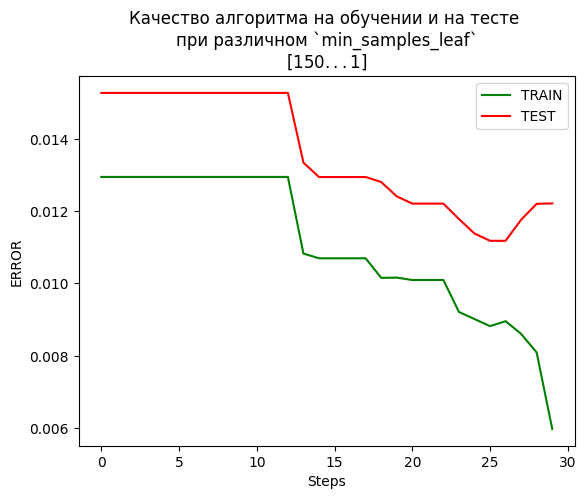

In [ ]:
from tqdm import tqdm
error_train_f1 = []
error_test_f1 = []
for min_samples_leaf in tqdm(range(150, 0, -5)):
  dtc = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
  dtc.fit(X_train, y_train)
  y_pred_train = dtc.predict(X_train)
  y_pred_test = dtc.predict(X_test)
  error_train_f1.append(1-f1_score(y_train, y_pred_train))
  error_test_f1.append(1-f1_score(y_test, y_pred_test))
title = 'Качество алгоритма на обучении и на тесте \nпри различном `min_samples_leaf`\n$[150 ... 1]$'
sns.lineplot(error_train_f1, color='green', label='TRAIN').set_title(title)
sns.lineplot(error_test_f1, color='red', label='TEST')
plt.ylabel('ERROR')
plt.xlabel('Steps')

Сделайте выводы сами!

# Task

Теперь ваш черед совершить научный прорыв! Думаю, вы уже изучили документацию к алгоритму DecisionTreeClassifier и знаете, какие гиперпараметры также можно "тюнить". Попробуйте подобрать такое сочетание гиперпараметров, при котором алгоритм даст наилучший скор на тесте. Можете использовать `GridSearch`! Помните, что вы также можете выбирать критерий неоднородности. Для любопытства, сравните текущий алгоритм классификации с Логистической Регрессией.

In [ ]:
# your hard work

# Что еще нам расскажет дерево или про интерпретацию результатов.

Когда мы использовали линейные модели, мы часто смотрели на коэффициенты (при условии, что данные отмасштабированы и использовалась регуляризация), мы могли оценивать значимость признаков для предсказания целевой переменной. Это в той или иной степени согласовывалось с коэффициентами корреляции для регрессии или значением t-критерия для классификации. В этом смысле модель может играть не только прогностическую роль, но и исследовательскую.

 Однако, что нам предложит дерево? У всех "деревянных" алгоритмов есть важный атрибут `feature_importances_`. По мнению ЖПТ:

 `feature_importances_` — это атрибут моделей дерева решений, который показывает важность каждого признака (feature) для принятия решений моделью. Важность признаков измеряется тем, насколько каждый признак помогает уменьшить неопределенность (или "неоднородность") данных при разбиении на узлы дерева.

### Как работает `feature_importances_`?

При каждом разбиении в дереве решений выбирается признак, который лучше всего разделяет данные. Это делается на основе критериев, таких как:
- **Информация по Энтропии** (Entropy)
- **Критерий Джини** (Gini impurity)
- **Критерий ошибки классификации** (Misclassification error)

Каждый раз, когда происходит разбиение по какому-то признаку, модель смотрит, насколько это разбиение уменьшает неопределенность. Чем больше неопределенность была уменьшена благодаря признаку, тем более значимым считается этот признак.

### Как рассчитывается важность признаков?

- Важность признака измеряется на основе **среднего уменьшения критерия неоднородности** (например, энтропии или критерия Джини) по всем узлам, где этот признак использовался для разбиения.
- Эти уменьшения взвешиваются по количеству объектов, которые попадают в каждую ветвь дерева. То есть разбиение, затрагивающее больше объектов, будет иметь больший вес.

Важно понимать, что сумма всех значений `feature_importances_` равна 1, так как они нормализованы.

### Как использовать `feature_importances_`?

`feature_importances_` можно использовать для понимания того, какие признаки оказывают наибольшее влияние на предсказания модели. Это полезно для анализа данных и отбора признаков, а также для интерпретации модели.


### Интерпретация:

- **Важные признаки**: Признаки с высокой важностью больше всего влияют на предсказания модели. Это те признаки, которые лучше всего разделяют данные при построении дерева решений.
- **Малозначимые признаки**: Признаки с низкими значениями могут оказаться менее полезными или избыточными в модели. Такие признаки можно попробовать исключить для упрощения модели, особенно если они оказывают незначительное влияние.

`feature_importances_` является мощным инструментом для объяснения того, как дерево решений использует входные данные и какие признаки считаются наиболее значимыми для предсказаний.

In [ ]:
dtc = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=25)
dtc.fit(X_train, y_train)
feature_importances = dtc.feature_importances_
feature_importances

array([3.41121732e-04, 4.06174609e-03, 9.84571210e-01, 7.12729111e-05,
       1.53093218e-03, 1.73935655e-04, 0.00000000e+00, 5.00543477e-03,
       4.21353714e-03, 3.08095632e-05])

Text(0, 0.5, 'Features')

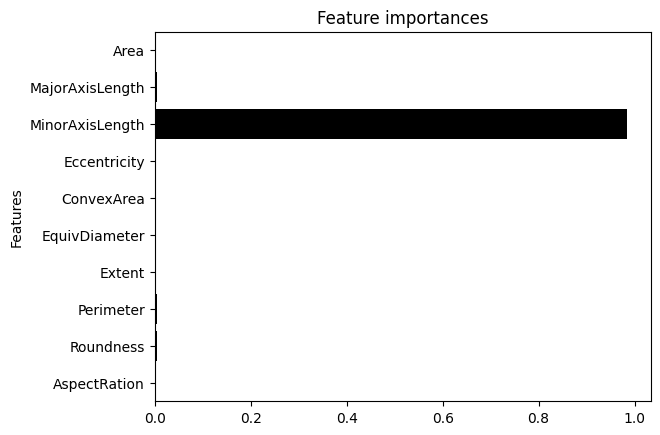

In [ ]:
sns.barplot(x=feature_importances, y=X.columns, color='black').set_title('Feature importances')
plt.ylabel('Features')

Видим, что модель выделила наиболее значимый признак при полном пренебрежении к остальным... Это может быть симптомом переобученности, но если вы оптимально подобрали гиперпараметры, то значит придется принять неизбежный факт исключительности данного признака.. Тут на самом деле есть смысл использовать алгоритмы-ансамбли деревьев, в которых такая картина менее вероятна, но это это еще предстоит изучить.

Изучим "самый влажный" признак и посмотрим на его t-критерий. Также поступим с наиболее "отвергнутым" признаком.

TtestResult(statistic=311.63139526622297, pvalue=0.0, df=18183.0)


Text(0.5, 0.98, '___MinorAxisLength___\n t-criterion: 311.63\n p-value: 0.0')

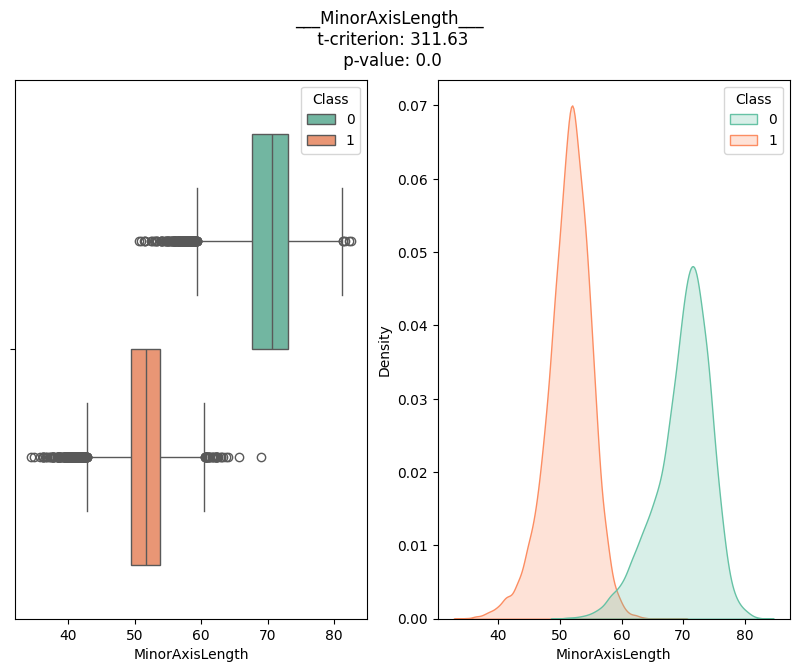

In [ ]:
from scipy import stats
ttest = stats.ttest_ind(X.loc[y==0, 'MinorAxisLength'], X.loc[y==1, 'MinorAxisLength'])
print(ttest)
info = f"___MinorAxisLength___\n t-criterion: {round(ttest.statistic, 2)}\n p-value: {ttest.pvalue}"
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.boxplot(x=X.MinorAxisLength, hue=y, fill=True, palette='Set2', ax=ax[0])
sns.kdeplot(x=X.MinorAxisLength, hue=y, fill=True, palette='Set2', ax=ax[1])
fig.suptitle(info)

Видим, что "любимый" моделью признак имеет пипец какие статистически значимые различия по группирующей переменной. Оценим один из самых малозначимых:

In [ ]:
X.columns[6]

'Extent'

TtestResult(statistic=42.94192560639996, pvalue=0.0, df=18183.0)


Text(0.5, 0.98, 'Extent\n t-criterion: 42.94\n p-value: 0.0')

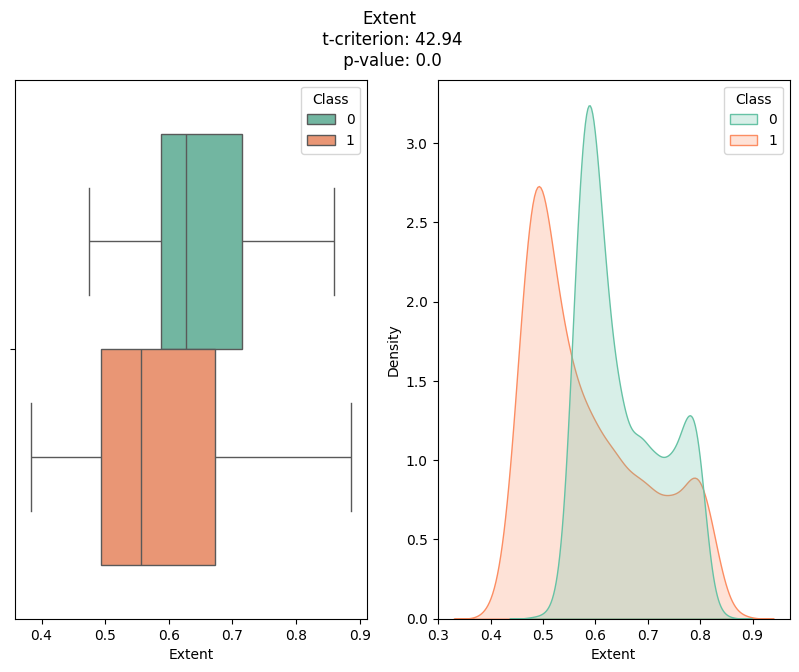

In [ ]:
ttest = stats.ttest_ind(X.loc[y==0, 'Extent'], X.loc[y==1, 'Extent'])
man = stats.mannwhitneyu(X.loc[y==0, 'Extent'], X.loc[y==1, 'Extent'])
print(ttest)
info = f"Extent\n t-criterion: {round(ttest.statistic, 2)}\n p-value: {ttest.pvalue}"
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.boxplot(x=X.Extent, hue=y, fill=True, palette='Set2', ax=ax[0])
sns.kdeplot(x=X.Extent, hue=y, fill=True, palette='Set2', ax=ax[1])
fig.suptitle(info)

Не смотря на то, что по признаку `Extent` также наблюдаются значимые различия, дерево им пренебрегло. Можно заподозрить некорректность результатов t-test в виду ненормальности распределения. Но непараметрический тест тоже говорит о значимых различиях.

```
MannwhitneyuResult(statistic=56968262.5, pvalue=0.0)
```
Вполне возможно, что некотторый вклад в ситуацию вносит наличие выбросов в данных. Хорошо было бы провести эксперимент по очистке данных.
Если хорошо подобрать гиперпараметры модели и почистить данные, может ситуация и изменится, однако факт тот, что у древесных алгоритмов "свой" взгляд на важность признаков и это качество также важно для исследовательских целей.

# Task

Очистите данные от выбросов и обучите модель с наилучшими (теперь это могут быть другие значения) гиперпараметрами. Оцените качество и интерпретируйте результат, оцените важность признаков. Поменялось ли что-то?? Важно отработать эту гипотезу экспериментально.

In [ ]:
# your hard work

# Задача регрессии

Будет очень не лишним изучить [статью от `sklearn`](https://scikit-learn.org/stable/modules/tree.html#tree).


Решающее дерево для регрессии — это алгоритм, который строит модель для предсказания числовой (не категориальной) переменной. Алгоритм разбиения и построения дерева схож с тем, что используется в задачах классификации, но отличается критерием, по которому происходит выбор разбиений и конечных предсказаний.

Пусть множество $R$ - множество объектов наблюдений, которые являются вершиной дерева. После разбиения получаем два множества $R_l$ и $R_r$. В общем виде, любое множество будем называть $R_m$.

## MSE - среднеквадратичная ошибка

$$H(R_m) = \frac{1}{|R_m|}\sum_{y\in R_m} (y - \overline{y}_m)^2$$

Где $\overline{y}_m$ - среднее значение целевой переменной для данного множества.

## Poisson - среднее отклонение Пуассона

$$H(R_m) = \frac{2}{|R_m|}\sum_{y\in R_m} (y \ln{\frac{y}{\overline{y}_m}} - y + \overline{y}_m)$$

Почитайте в статье, в каких случаях он предпочтительнее!

## MAE - средняя абсолютная ошибка

$$H(R_m) = \frac{1}{|R_m|}\sum_{y\in R_m} |y - median(y_m)|$$

Также прочтите в статье о целесообразности применения этого функционала разбиения.

## Алгоритм работы дерева для регрессии:

1. Для каждой возможной точки разбиения $t$ выбираем признак $x_j$, по которому производится разбиение, и делим набор данных на две части: $R_l$ (левая часть) и $R_r$ (правая часть).
2. Для каждой из этих частей вычисляется среднее значение целевой переменной $\overline{y}_l$ и $\overline{y}_r$. Эти значения являются выходными (предсказанными) для каждой вершины.

3. Общее качество для разбиения (аналог Impurity) рассчитывается как сумма ошибок для левой и правой частей, взвешенных по количеству объектов в каждой части:

$$Q_t(R, j, s) = \frac{|R_l|}{|R|} H(R_l) + \frac{|R_r|}{|R|} H(R_r) \to min_{j, s}$$



## Пример с криволинейной зависимостью.

Даны 100 наблюдений в одномерном признаковом пространстве, объясняющих некоторую вещественную величину. Зависимость описывается некоторым криволинейным законом и не имеет шума.

Text(0.5, 1.0, 'Тригонометрический закон')

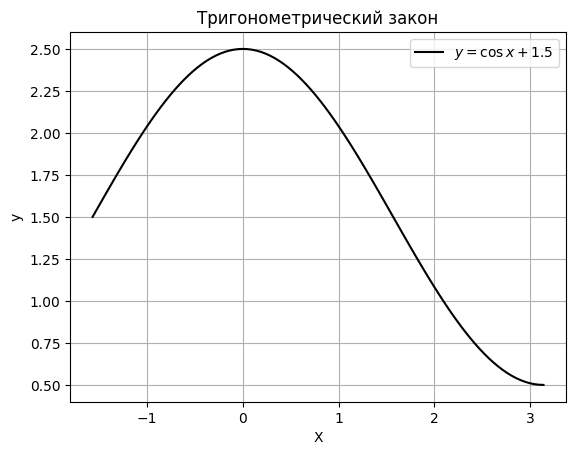

In [21]:
X = np.linspace(-.5*np.pi, np.pi, 100)
y = np.cos(X) + 1.5
plt.plot(X, y, label="$y = \cos{x} + 1.5$", c='black')
plt.grid()
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Тригонометрический закон')

Если текущий набор данных представим в виде множества $R = \{(x_i, y_i)\}_{i=1}^n$ входящего в корневой узел, то предлагаю ознакомиться с симулятором логического деления данного узла:

In [ ]:
# @title Симулятор разделения по количественному признаку в задаче регрессии

min= -.5*np.pi + .01
max= np.pi - .01

slider_tr = widgets.FloatSlider(
    value= 0,
    min= min,
    max= max,
    step=.01,
    description='Порог'
)

def tr_data(x_tr:float)->tuple:
  'по порогу делит данные и возвращает все по целевой переменной'
  y_left = y[X < x_tr]
  y_right = y[X >= x_tr]
  return y_left.mean(), y_right.mean(), y_left, y_right

def MSE(y:np.ndarray)->float:
  return ((y - y.mean())**2).mean()

def MAE(y:np.ndarray)->float:
  return abs(y - np.median(y)).mean()

def poisson(y:np.ndarray)->float:
  return (y*np.log(y/y.mean()) - y + y.mean()).sum()*2/y.shape[0]

def Qual(x_tr:float)->tuple:
  y_l_mean, y_r_mean, y_l, y_r = tr_data(x_tr)

  mse = (y_l.shape[0]*MSE(y_l) + y_r.shape[0]*MSE(y_r))/100
  mae = (y_l.shape[0]*MAE(y_l) + y_r.shape[0]*MAE(y_r))/100
  pois = (y_l.shape[0]*poisson(y_l) + y_r.shape[0]*poisson(y_r))/100
  return y_l_mean, y_r_mean, mse, mae, pois

qu_fun = np.vectorize(Qual)
tr_plot = np.linspace(min, max, 50)
mse_plot, mae_plot, pois_plot = qu_fun(tr_plot)[2:]

def update_plot(slider_tr):

    slider_tr = float(slider_tr)
    y_l_mean, y_r_mean, mse, mae, pois = Qual(slider_tr)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.lineplot(x=X, y=y, color='black', ax=ax[0]).set_title('Закон зависимости целевой переменной от числового признака.')
    ax[0].axvline(slider_tr, color='black', linestyle='--', label=f'Порог: {round(slider_tr ,2)}')
    sns.lineplot(x=[min, slider_tr], y=[y_l_mean, y_l_mean], color='red', ax=ax[0], label=f'PREDICT IF TRUE: {round(y_l_mean, 2)}')
    sns.lineplot(x=[slider_tr, max], y=[y_r_mean, y_r_mean], color='green', ax=ax[0], label=f'PREDICT IF FALSE: {round(y_r_mean, 2)}')
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('y')
    sns.lineplot(x=tr_plot, y=mse_plot, color='green', ax=ax[1], label=f'MSE: {round(mse, 2)}').set_title('Функционал качества разбиения $Q_t(R, j, s)$.')
    sns.lineplot(x=tr_plot, y=mae_plot, color='blue', ax=ax[1], label=f'MAE: {round(mae, 2)}')
    sns.lineplot(x=tr_plot, y=pois_plot, color='pink', ax=ax[1], label=f'POISSON: {round(pois, 2)}')
    ax[1].set_xlabel('Значение порога')
    ax[1].set_ylabel('Качество')
    ax[1].scatter([slider_tr, slider_tr, slider_tr], [mse, mae, pois], color='red', s=60)

    plt.show()


out = widgets.Output()

def on_slider_change(change):
    A_value = slider_tr.value

    with out:
        clear_output(wait=True)
        update_plot(A_value)

slider_tr.observe(on_slider_change, 'value')

display(widgets.VBox([slider_tr]))
display(out)

Output()

Если мы в этом симуляторе подберем наилучший порог, то мы так построим дерево глубиной 1, которое сможет уже как-то предсказывать нашу целевую количественную переменну. Покажем это в виде схемы:

[Text(0.5, 0.75, 'x[0] <= 1.595\nsquared_error = 0.458\nsamples = 100\nvalue = 1.705'),
 Text(0.25, 0.25, 'squared_error = 0.099\nsamples = 67\nvalue = 2.127'),
 Text(0.75, 0.25, 'squared_error = 0.091\nsamples = 33\nvalue = 0.848')]

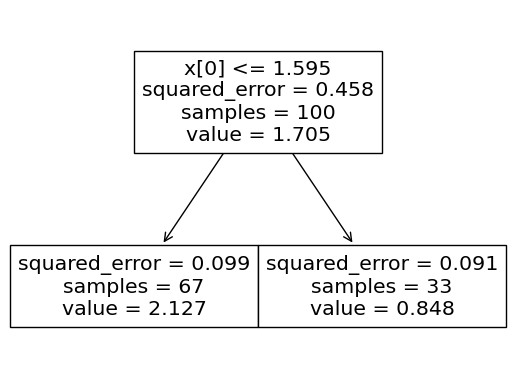

In [ ]:
# @title Узловая вершина
clf = tree.DecisionTreeRegressor(max_depth = 1)
clf = clf.fit(X.reshape((X.shape[0], 1)), y)
tree.plot_tree(clf)

Изучите данную отрисовку. Что она нам показывает?

### Ступенчатое приближение.

Вывод: При однократном разделении корневого узла в задаче регрессии мы получаем возможность предсказывать только две константы - два усредненных значения целевой переменной для левого и правого множества. Мы получаем СТУПЕНЧАТОЕ ПРИБЛИЖЕНИЕ! Чтобы точнее аппроксимировать данную условную зависимость, необходимо увеличить число ступеник или дать дереву вырасти глубже. Пример для того же тригонометрического закона:

In [22]:
# @title Точность и глубина

slider_depth = widgets.FloatSlider(
    value= 2,
    min= 1,
    max= 15,
    step=1,
    description='Max depth'
)

XX = X.reshape((X.shape[0], 1))

def update_plot(slider_depth):

    slider_depth = int(slider_depth)
    clf = tree.DecisionTreeRegressor(max_depth = slider_depth)
    clf.fit(XX, y)
    y_pred = clf.predict(XX)

    plt.plot(X, y, label="$y_{true} = \cos{x} + 1.5$", c='black')
    plt.plot(X, y_pred, label=f"y predict\nRMSE: {round(((y-y_pred)**2).mean()**.5, 4)}", c='red')
    plt.grid()
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Приближение Тригонометрического закона')

    plt.show()


out = widgets.Output()

def on_slider_change(change):
    A_value = slider_depth.value

    with out:
        clear_output(wait=True)
        update_plot(A_value)

slider_depth.observe(on_slider_change, 'value')

display(widgets.VBox([slider_depth]))
display(out)

Output()

Во всей красе мы увидили поведение алгоритма в задаче регрессии. При достаточной сложности алгоритма, он способен описать практически любую криволинейную зависимость.

## Gauss's noice with DT Regressor

Предыдущий пример показывает поведение алгоритма на криволинейной зависимости идеального вида. В природе так не бывает. Данные всегда зашумлены и нам необходимо посмотреть на работу дерева с данными, имеющими некоторый шум.

Ниже предложен интерактивный симулятор обучения регрессионного "деревянного" алгоритма с возможностью изменять глубину дерева. Показан классический пример с оценкой модели на обучающей и тестовой выборках. Поэкспериментируйте с ним и внимательно изучити особенности его работы.

In [23]:
# @title Точность и глубина

from sklearn.metrics import mean_squared_error

slider_depth = widgets.FloatSlider(
    value= 2,
    min= 1,
    max= 15,
    step=1,
    description='Max depth'
)

X = np.linspace(-.5*np.pi, 2*np.pi, 100)
X_test = X+.1
y_train = np.cos(X) + np.random.randn(100)*.4
y_test = np.cos(X+.05) + np.random.randn(100)*.2

XX = X.reshape((X.shape[0], 1))
XX_test = X_test.reshape((X.shape[0], 1))



def update_plot(slider_depth):

    slider_depth = int(slider_depth)
    clf = tree.DecisionTreeRegressor(max_depth = slider_depth)#, criterion='absolute_error')
    clf = clf.fit(XX, y_train)
    y_train_predict = clf.predict(XX)
    y_test_predict = clf.predict(XX_test)
    mse_train = mean_squared_error(y_train, y_train_predict)
    mse_test = mean_squared_error(y_test, y_test_predict)
    loss = pd.Series({'MSE_Train':mse_train, 'MSE_Test':mse_test})

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    sns.scatterplot(x=X, y=y_train, label='TRAIN DATA', color='black', ax=ax[0])
    sns.lineplot(x=X, y=y_train_predict.ravel(), color='red', label='Predict on Train', ax=ax[0])
    ax[0].set_xlabel('$X_{train}$')
    ax[0].set_ylabel('$y_{train}$')

    sns.scatterplot(x=X_test, y=y_test, label='TEST DATA', color='green', ax=ax[1])
    sns.lineplot(x=X_test, y=y_test_predict.ravel(), color='red', label='Predict on Test', ax=ax[1])
    ax[1].set_xlabel('$X_{test}$')
    ax[1].set_ylabel('$y_{test}$')

    sns.barplot(x=loss.index, y=loss, color='black', ax=ax[2])
    ax[2].set_xlabel('Mode')
    ax[2].set_ylabel('Loss')
    ax[2].set_ylim(0, .6)


    fig.suptitle('Приближение зашумленного Тригонометрического закона')

    plt.show()


out = widgets.Output()

def on_slider_change(change):
    A_value = slider_depth.value

    with out:
        clear_output(wait=True)
        update_plot(A_value)

slider_depth.observe(on_slider_change, 'value')

display(widgets.VBox([slider_depth]))
display(out)

Output()

Итак, какие вы сделали выводы? Сначала сделайте свои выводы, а потом читайте далее. Лично я заметил:
* Достаточно быстрая переобучаемость
* Переобученный алгоритм плохо прогнозирует на тестовых данных но дает исчезающе малую ошибку на тренировочных.
* Наблюдения, которые сильнее отклоняются от тренда провоцирует алгоритм делать "Пики" на ломанной линии. Это тот пример "запоминания" деревом специфических флуктуаций в данных с которым также можно бороться ограничивая минимальное количество объектов в листе. Выбросы очень любят "уединяться" в терминальных вершинах (листьях)! Также на НЕСТАБИЛЬНОСТЬ может влиять тот факт, что мы использовали функционал качества MSE. Мы со времен линейных моделей помним его "любовь" к большим отклонениям. Выбросы + MSE - это рецепт как свести алгоритм с ума...

Возникает в уме гипотеза, что, может быть, MAE немного стабилизирует алгоритм? Надо проверять...

In [24]:
# @title Точность и глубина

slider_depth = widgets.FloatSlider(
    value= 2,
    min= 1,
    max= 15,
    step=1,
    description='Max depth'
)

X = np.linspace(-2*np.pi, 2*np.pi, 100)
y = np.cos(X)*2 + np.random.randn(100)*.6 + 2

XX = X.reshape((-1, 1))


def update_plot(slider_depth):

    slider_depth = int(slider_depth)
    clf = tree.DecisionTreeRegressor(max_depth = slider_depth)
    clf.fit(XX, y)
    y_pred = clf.predict(XX)

    clf_mae = tree.DecisionTreeRegressor(max_depth = slider_depth, criterion='absolute_error')
    clf_mae.fit(XX, y)
    y_pred_mae = clf_mae.predict(XX)


    plt.subplots(figsize=(8, 6))
    sns.scatterplot(x=X, y=y, label="$y_{true} = \cos{x} + 2 + \epsilon$", color='black')
    plt.plot(X, y_pred, label=f"Algorithm MSE", c='red')
    plt.plot(X, y_pred_mae, label=f"Algorithm MAE", c='green')
    plt.grid()
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Приближение Тригонометрического закона')

    plt.show()


out = widgets.Output()

def on_slider_change(change):
    A_value = slider_depth.value

    with out:
        clear_output(wait=True)
        update_plot(A_value)

slider_depth.observe(on_slider_change, 'value')

display(widgets.VBox([slider_depth]))
display(out)

Output()

Позапускав этот симулятор несколько раз, напрашивается вывод, что до определенного момента MAE ведет себя в некоторой мере стабильнее. Именно в некоторой мере и не везде, однако некоторые пики все таки сглаживаются. Все это делает целесообразным при обучении модели на реальных данных тестирование алгоритма используя различные функционалы качества.

# Выводы

Если вы честно дошли до этого раздела, значит вы проделали огромную работу! Не забудьте себя поощрить и похвалить! Деревья - это очень интересный подход в решении прогностических задач в машинном обучении. Он не сказать чтобы был сильно новым.. Зарождалась эта метода в 50-х годах. Тем не менее, даже сейчас нет-нет да придумывают еще более совершенный алгоритм на основе решающего дерева. Вариаций на тему очень много, но в основе лежат те идеи, с которыми мы познакомились в этом конспекте.

Озаботьтесь практикой! Вам предложен (и будут предложены еще) проектные работы, в рамках которых не забывайте использовать деревья и все подходы, с которыми мы тут познакомились. Желаю успехов!